Data Processing for Sentiment Analysis Model:

**1. Importing Data:**
   - The first step in building our sentiment analysis model involved importing the dataset into pandas DataFrames. This allowed for easy manipulation and exploration of the data.

**2. Dataset Refinement:**
   - Upon inspection, it became evident that certain fields in the dataset were irrelevant to our sentiment analysis task. These extraneous fields were removed to streamline the dataset and focus solely on the relevant information. Since we are focusing on sentiment analysis to process reviews,fields like love, surprise and fear were unessasary. Furthermore the data for these perticular fields is a lot more limited.

   - Another step that was taken was to combine fields in order to make this a binary classfication task. While Joy was our primary Positive Sentiment, Anger and Sadness were combined to create our Negetive Sentiment in our dataset.

**3. Label Transformation:**
   - Since our model aims to predict sentiment as either positive or negative, we transformed the original emotion labels into a binary format. This simplification of the classification task enables the model to learn more effectively from the provided data.

In [ ]:
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

drive.mount("/content/drive", force_remount=True)
%cd drive/MyDrive/EmotionsDataset

try:
  from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except ModuleNotFoundError:
    %pip install vaderSentiment

#Read the text files into datasets
train_df = pd.read_csv('train.txt', delimiter=';', header=None, names=['text', 'emotion'])
test_df = pd.read_csv('test.txt', delimiter=';', header=None, names=['text', 'emotion'])
val_df = pd.read_csv('val.txt', delimiter=';', header=None, names=['text', 'emotion'])
train_df

Mounted at /content/drive
/content/drive/MyDrive/EmotionsDataset
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.9 MB/s eta 0:00:00


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [ ]:
train_df["emotion"].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [ ]:
train_df["emotion"].value_counts()

emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

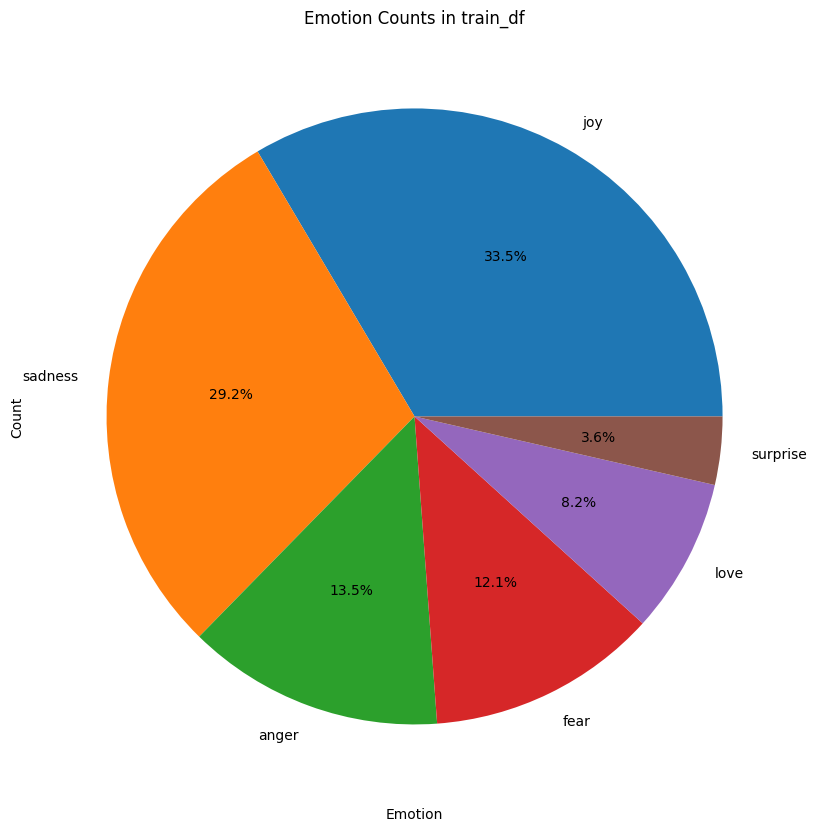

In [ ]:
train_df['emotion'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10))
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Counts in train_df')
plt.show()

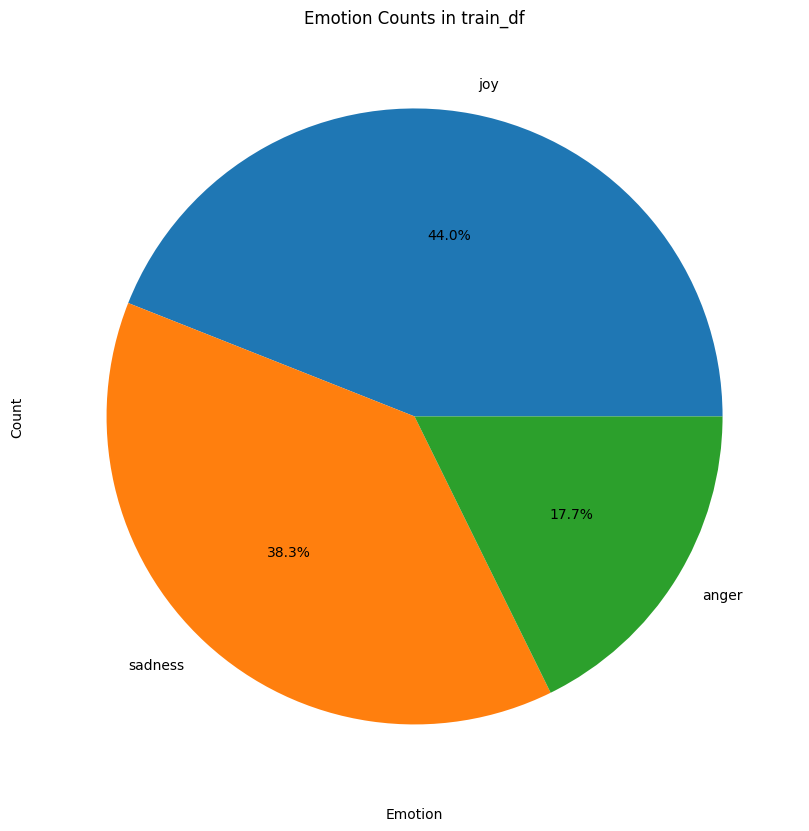

In [ ]:
emotions_to_remove = ['fear', 'love', 'surprise']

train_df = train_df[~train_df['emotion'].isin(emotions_to_remove)]
test_df = test_df[~test_df['emotion'].isin(emotions_to_remove)]
val_df = val_df[~val_df['emotion'].isin(emotions_to_remove)]

train_df['emotion'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10))
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Counts in train_df')
plt.show()

In [ ]:
# Mapping emotions to numerical values
emotion_mapping = {'anger': 0, 'sadness': 0, 'joy':1}

train_df['emotion'] = train_df['emotion'].map(emotion_mapping)
test_df['emotion'] = test_df['emotion'].map(emotion_mapping)
val_df['emotion'] = val_df['emotion'].map(emotion_mapping)

<ipython-input-6-ac7ef50e4671>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['emotion'] = train_df['emotion'].map(emotion_mapping)


In [ ]:
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

tqdm.pandas()

#VanderSentiment used to analyze and assign numerical values for sentiment for each text field being trained and tested (Added more features to make a more accurate prediction)
def addFeatures(row):
    sentiment = analyzer.polarity_scores(row['text'])
    row["positive"] = sentiment['pos']
    row["negative"] = sentiment['neg']
    row['neutral'] = sentiment['neu']
    row['compound'] = sentiment['compound']

    return row

train_df = train_df.progress_apply(addFeatures, axis=1)
val_df = val_df.progress_apply(addFeatures, axis = 1)

100%|██████████| 1529/1529 [00:03<00:00, 474.27it/s]


In [ ]:
train_df

,text,emotion,positive,negative,neutral,compound
0,i didnt feel humiliated,0,0.404,0.000,0.596,0.2584
1,i can go from feeling so hopeless to so damned...,0,0.262,0.219,0.519,0.0821
2,im grabbing a minute to post i feel greedy wrong,0,0.000,0.403,0.597,-0.6597
4,i am feeling grouchy,0,0.234,0.453,0.312,-0.3400
5,ive been feeling a little burdened lately wasn...,0,0.101,0.294,0.605,-0.4346
...,...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,0.092,0.103,0.806,-0.0772
15996,i am now turning and i feel pathetic that i am...,0,0.000,0.163,0.837,-0.5719
15997,i feel strong and good overall,1,0.608,0.000,0.392,0.7351
15998,i feel like this was such a rude comment and i...,0,0.282,0.154,0.564,0.3612


Training the Sentiment Analysis Model:

**1. Model Architecture Definition:**
   - The first step in training our sentiment analysis model was to define the architecture. We constructed a deep learning model using TensorFlow and Keras, comprising multiple layers to process both text and numeric data. The model included embedding layers for text input, LSTM layers for sequential data processing, dense layers for feature extraction, dropout layers to prevent overfitting and a final output layer for sentiment prediction.

**2. Data Preparation:**
   - Before training the model, we prepared the input data by tokenizing and padding the text sequences to ensure uniform length. Additionally, the numeric features were normalized to facilitate efficient training. The training and validation datasets were then organized into batches to feed into the model during training.

**3. Model Compilation:**
   - With the architecture defined and the data prepared, the next step was to compile the model. We specified the loss function (binary cross-entropy) and optimizer (Adam) to use during training. Additionally, we selected evaluation metrics such as accuracy to monitor the model's performance during training.

**4. Monitoring Training Progress:**
   - Throughout the training process, we monitored various metrics such as training loss, validation loss, and accuracy to assess the model's performance and detect signs of overfitting. Visualizations such as learning curves and validation plots were used to analyze the model's behavior and make informed decisions regarding training duration and hyperparameter tuning.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 5000
max_length = 100
trunc_type='post'

tokenizer = Tokenizer(num_words = vocab_size, oov_token = '')
tokenizer.fit_on_texts(train_df['text'])
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(val_df['text'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, truncating=trunc_type)

In [ ]:
# Text input
text_input_layer = tf.keras.layers.Input(shape=(max_length,))
embedding_layer = tf.keras.layers.Embedding(vocab_size, 32, input_length=max_length)(text_input_layer)
bidirectional_lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedding_layer)
dropout_lstm1 = tf.keras.layers.Dropout(0.2)(bidirectional_lstm1)
bidirectional_lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(dropout_lstm1)
dropout_lstm2 = tf.keras.layers.Dropout(0.2)(bidirectional_lstm2)
dense_text = tf.keras.layers.Dense(128, activation='relu')(dropout_lstm2)

# Numeric input
numeric_input_layer = tf.keras.layers.Input(shape=(4,))
dense_numeric = tf.keras.layers.Dense(64, activation='relu')(numeric_input_layer)

# Concatenate text and numeric features
merged_features = tf.keras.layers.Concatenate(axis=1)([dense_text, dense_numeric])
dense_combined = tf.keras.layers.Dense(64, activation='relu')(merged_features)
dropout_combined = tf.keras.layers.Dropout(0.2)(dense_combined)

# Output layer
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_combined)

LstmModel = tf.keras.models.Model(inputs=[text_input_layer, numeric_input_layer], outputs=output_layer)
LstmModel.compile(loss="binary_crossentropy", optimizer='adam', metrics=['acc'])
LstmModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 32)              160000    ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 100, 128)             49664     ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 dropout (Dropout)           (None, 100, 128)             0         ['bidirectional[0][0]']   

In [ ]:
numeric_inputs_train = np.array(list(zip(
    train_df['positive'],
    train_df['negative'],
    train_df['neutral'],
    train_df['compound']
)))

numeric_inputs_val = np.array(list(zip(
    val_df['positive'],
    val_df['negative'],
    val_df['neutral'],
    val_df['compound']
)))

history = LstmModel.fit([train_padded, numeric_inputs_train], np.array(train_df['emotion']), epochs=3, validation_data = ([validation_padded, numeric_inputs_val], np.array(val_df['emotion'])))

Epoch 1/3
381/381 [==============================] - 38s 72ms/step - loss: 0.3317 - acc: 0.8694 - val_loss: 0.1570 - val_acc: 0.9431
Epoch 2/3
381/381 [==============================] - 11s 29ms/step - loss: 0.0860 - acc: 0.9737 - val_loss: 0.1147 - val_acc: 0.9595
Epoch 3/3
381/381 [==============================] - 10s 25ms/step - loss: 0.0466 - acc: 0.9878 - val_loss: 0.1041 - val_acc: 0.9719


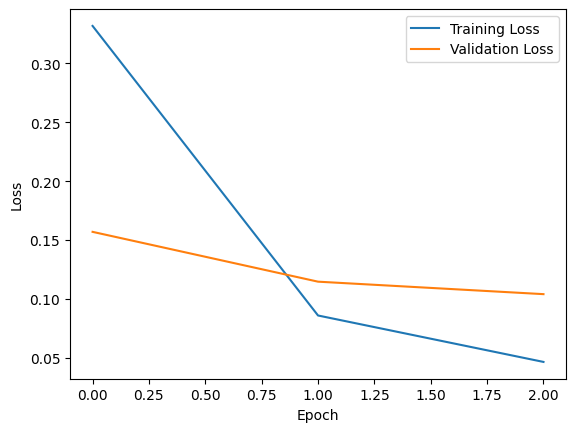

In [ ]:
#Plot Training and Validation loss between epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

48/48 [==============================] - 1s 12ms/step


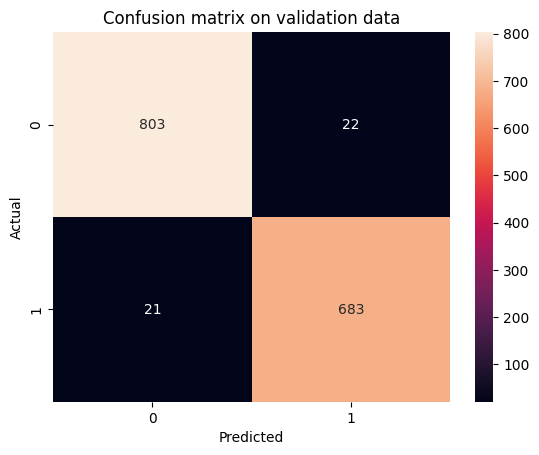

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = np.array(val_df['emotion'])
y_pred = LstmModel.predict([validation_padded, numeric_inputs_val])
y_pred = (y_pred > 0.5).astype('int32')

confusionMatrix = confusion_matrix(y_true, y_pred)

sns.heatmap(confusionMatrix, annot=True, fmt='g')
plt.title('Confusion matrix on validation data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
def predictEmotion(text):
  sequences = tokenizer.texts_to_sequences([text])
  padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

  sentiment = analyzer.polarity_scores(text)
  pos = sentiment['pos']
  neg = sentiment['neg']
  neu = sentiment['neu']
  comp = sentiment['compound']

  numeric_inputs = [np.array([pos, neg, neu, comp])]

  return LstmModel.predict([padded, np.array(numeric_inputs)])[0][0]

In [ ]:
happyText = "I am really happy with this product!"
angryText = "Very Bad Product. Upset with how horribly manyfactured it is."

happyPred = predictEmotion(happyText)
angryPred = predictEmotion(angryText)

print("For the good review: " + str(bool(round(happyPred))))
print("For the bad review: " + str(bool(round(angryPred))))

1/1 [==============================] - 0s 42ms/step
For the good review: True
For the bad review: False


In [16]:
%%capture test

correct = 0
wrong = 0
for index, row in test_df.iterrows():
  prediction = predictEmotion(row['text'])
  rounded_prediction = round(prediction)
  if rounded_prediction == row['emotion']:
    correct += 1
  else:
    wrong += 1

In [17]:
print(f"Correct: {correct}, Wrong: {wrong}")

Correct: 1508, Wrong: 43
